In [87]:

# What is your house worth? What is your neighbor's house worth? We can screen scrape houses from Zillow and compare all the prices of all the 
# homes, based on 'Price', 'Beds', 'Baths', 'Square Footage', and 'ZipCode' to determine which houses are relatively more expensive when compared 
# to their peers and likewise, we can determine which homes are relatively less expensive when compared to their peers. By doing this, we can 
# find the relative value of all houses compared to all other houses.


In [14]:

import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException, ElementClickInterceptedException
from bs4 import BeautifulSoup
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")

# Options for Chrome
chrome_options = Options()
# chrome_options.add_argument("--headless") # uncomment if you don't want to see the browser window open
chrome_options.add_argument("--disable-gpu")
chrome_options.add_argument("--window-size=1920x1080")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")
chrome_options.add_argument('user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36')

# Start a new Chrome session
driver = webdriver.Chrome(options=chrome_options)

url = 'https://www.zillow.com/seattle-wa/'
driver.get(url)

all_homes = []

def scroll_to_load(driver):
    SCROLL_PAUSE_TIME = 2
    last_height = driver.execute_script("return document.body.scrollHeight")
    while True:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(SCROLL_PAUSE_TIME)
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

while True:
    scroll_to_load(driver)

    # Parse the page content
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    # Extract data
    property_cards = soup.find_all('div', class_='StyledPropertyCardDataWrapper-c11n-8-102-0__sc-hfbvv9-0')
    for card in property_cards:
        try:
            # Price
            price = card.find('span', {'data-test': 'property-card-price'}).text.strip()
            
            # Address
            address_tag = card.find('a', {'data-test': 'property-card-link'})
            address = address_tag.find('address', {'data-test': 'property-card-addr'}).text.strip()
            
            # Details (beds, baths, sqft)
            details = card.find('div', class_='StyledPropertyCardDataArea-c11n-8-102-0__sc-10i1r6-0 gAnZoM').ul.find_all('li')
            beds = details[0].text.strip()
            baths = details[1].text.strip() if len(details) > 1 else 'N/A'
            sqft = details[2].text.strip() if len(details) > 2 else 'N/A'

            all_homes.append([address, price, beds, baths, sqft])
        except AttributeError:
            continue
    
    # Try to go to the next page
    try:
        next_button = driver.find_element(By.XPATH, "//a[@title='Next page']")
        driver.execute_script("arguments[0].click();", next_button)
        time.sleep(5)  # Adjust sleep time if necessary to allow the page to load completely
    except NoSuchElementException:
        print("No more pages to scrape.")
        break
    except ElementClickInterceptedException:
        print("Next button not clickable. Trying again.")
        time.sleep(2)

driver.quit()

# Create DataFrame
df = pd.DataFrame(all_homes, columns=['Address', 'Price', 'Beds', 'Baths', 'SqFt'])

# Convert data types
df['Price'] = df['Price'].str.replace('[\$,]', '', regex=True).astype(float)
df['Beds'] = df['Beds'].str.extract('(\d+)').astype(float)
df['Baths'] = df['Baths'].str.extract('(\d+)').astype(float)
df['SqFt'] = df['SqFt'].str.replace(',', '').str.extract('(\d+)').astype(float)

print(df.shape)
display(df.head())


No more pages to scrape.
(220, 5)


Address     Price  Beds  Baths  \
0             915 NW 105th Street, Seattle, WA 98177  800000.0   2.0    1.0   
1     3015 SW Avalon Way UNIT 305, Seattle, WA 98126  439950.0   2.0    2.0   
2  2706 Westlake Avenue N UNIT 76, Seattle, WA 98109  399000.0   2.0    1.0   
3       624 W Ewing Street UNIT 3, Seattle, WA 98119  250000.0   1.0    1.0   
4              9725 51st Avenue S, Seattle, WA 98118  300000.0   1.0    1.0   

    SqFt  
0  820.0  
1  810.0  
2  583.0  
3  450.0  
4  530.0

In [15]:

from sklearn.preprocessing import StandardScaler

# Drop rows will NAN
print(df.shape)
df = df.dropna(subset=['Price', 'Beds', 'Baths', 'SqFt'])
print(df.shape)


# Save the original values
df['Original_Price'] = df['Price']
df['Original_Beds'] = df['Beds']
df['Original_Baths'] = df['Baths']
df['Original_SqFt'] = df['SqFt']

# Standardize the features
scaler = StandardScaler()
df[['Price', 'Beds', 'Baths', 'SqFt']] = scaler.fit_transform(df[['Price', 'Beds', 'Baths', 'SqFt']])


# Create a new 'ZipCode' column by extracting the last 5 characters of the 'Address' column
df['ZipCode'] = df['Address'].str[-5:]

display(df.head(20))


(220, 5)
(220, 5)


Address     Price      Beds  \
0              915 NW 105th Street, Seattle, WA 98177 -0.301801 -0.599625   
1      3015 SW Avalon Way UNIT 305, Seattle, WA 98126 -0.353307 -0.599625   
2   2706 Westlake Avenue N UNIT 76, Seattle, WA 98109 -0.359165 -0.599625   
3        624 W Ewing Street UNIT 3, Seattle, WA 98119 -0.380480 -1.424110   
4               9725 51st Avenue S, Seattle, WA 98118 -0.373327 -1.424110   
5                 4315 W Semple St, Seattle, WA 98199  3.159350  1.873829   
6               108 NW 75th Street, Seattle, WA 98117 -0.259171  0.224860   
7                508 23rd Avenue E, Seattle, WA 98112 -0.280343  1.049344   
8              1538 NE 62nd Street, Seattle, WA 98115 -0.287496  0.224860   
9             1524 NE 103rd Street, Seattle, WA 98125 -0.312530  1.049344   
10          8030 Meridian Avenue N, Seattle, WA 98103 -0.251732  0.224860   
11             915 NW 105th Street, Seattle, WA 98177 -0.301801 -0.599625   
12     3015 SW Avalon Way UNIT 305, Seattle, WA 98126 -0.353307 -0.599625   
13  2706 Westlake Avenue N UNIT 76, Seattle, WA 98109 -0.359165 -0.599625   
14       624 W Ewing Street UNIT 3, Seattle, WA 98119 -0.380480 -1.424110   
15              9725 51st Avenue S, Seattle, WA 98118 -0.373327 -1.424110   
16                4315 W Semple St, Seattle, WA 98199  3.159350  1.873829   
17              108 NW 75th Street, Seattle, WA 98117 -0.259171  0.224860   
18               508 23rd Avenue E, Seattle, WA 98112 -0.280343  1.049344   
19             1538 NE 62nd Street, Seattle, WA 98115 -0.287496  0.224860   

       Baths      SqFt  Original_Price  Original_Beds  Original_Baths  \
0  -0.896258 -0.436162        800000.0            2.0             1.0   
1  -0.192055 -0.438137        439950.0            2.0             2.0   
2  -0.896258 -0.482963        399000.0            2.0             1.0   
3  -0.896258 -0.509226        250000.0            1.0             1.0   
4  -0.896258 -0.493429        300000.0            1.0             1.0   
5   2.624756  3.118927      24995000.0            5.0             6.0   
6  -0.192055 -0.151802       1098000.0            3.0             2.0   
7   0.512148 -0.037268        950000.0            4.0             3.0   
8  -0.192055 -0.203145        900000.0            3.0             2.0   
9   0.512148 -0.080712        725000.0            4.0             3.0   
10  0.512148 -0.286083       1150000.0            3.0             3.0   
11 -0.896258 -0.436162        800000.0            2.0             1.0   
12 -0.192055 -0.438137        439950.0            2.0             2.0   
13 -0.896258 -0.482963        399000.0            2.0             1.0   
14 -0.896258 -0.509226        250000.0            1.0             1.0   
15 -0.896258 -0.493429        300000.0            1.0             1.0   
16  2.624756  3.118927      24995000.0            5.0             6.0   
17 -0.192055 -0.151802       1098000.0            3.0             2.0   
18  0.512148 -0.037268        950000.0            4.0             3.0   
19 -0.192055 -0.203145        900000.0            3.0             2.0   

    Original_SqFt ZipCode  
0           820.0   98177  
1           810.0   98126  
2           583.0   98109  
3           450.0   98119  
4           530.0   98118  
5         18823.0   98199  
6          2260.0   98117  
7          2840.0   98112  
8          2000.0   98115  
9          2620.0   98125  
10         1580.0   98103  
11          820.0   98177  
12          810.0   98126  
13          583.0   98109  
14          450.0   98119  
15          530.0   98118  
16        18823.0   98199  
17         2260.0   98117  
18         2840.0   98112  
19         2000.0   98115

In [16]:

# Here is one attempt to detemine if houses are overvalued or undervalued, relative to their peers.

from sklearn.cluster import KMeans

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=0)
df['Cluster'] = kmeans.fit_predict(df[['Price', 'Beds', 'Baths', 'SqFt']])

# Calculate Z-scores
df['Price_Z'] = (df['Price'] - df['Price'].mean()) / df['Price'].std()


# Determine if a house is overpriced; we don't need another column for 'underpriced'...it's either overpriced or not
df['Overpriced'] = df['Price_Z'] > 1

# Display the results with original values
display(df.head(10))


C:\Users\ryan_\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ryan_\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Address     Price      Beds  \
0             915 NW 105th Street, Seattle, WA 98177 -0.301801 -0.599625   
1     3015 SW Avalon Way UNIT 305, Seattle, WA 98126 -0.353307 -0.599625   
2  2706 Westlake Avenue N UNIT 76, Seattle, WA 98109 -0.359165 -0.599625   
3       624 W Ewing Street UNIT 3, Seattle, WA 98119 -0.380480 -1.424110   
4              9725 51st Avenue S, Seattle, WA 98118 -0.373327 -1.424110   
5                4315 W Semple St, Seattle, WA 98199  3.159350  1.873829   
6              108 NW 75th Street, Seattle, WA 98117 -0.259171  0.224860   
7               508 23rd Avenue E, Seattle, WA 98112 -0.280343  1.049344   
8             1538 NE 62nd Street, Seattle, WA 98115 -0.287496  0.224860   
9            1524 NE 103rd Street, Seattle, WA 98125 -0.312530  1.049344   

      Baths      SqFt  Original_Price  Original_Beds  Original_Baths  \
0 -0.896258 -0.436162        800000.0            2.0             1.0   
1 -0.192055 -0.438137        439950.0            2.0             2.0   
2 -0.896258 -0.482963        399000.0            2.0             1.0   
3 -0.896258 -0.509226        250000.0            1.0             1.0   
4 -0.896258 -0.493429        300000.0            1.0             1.0   
5  2.624756  3.118927      24995000.0            5.0             6.0   
6 -0.192055 -0.151802       1098000.0            3.0             2.0   
7  0.512148 -0.037268        950000.0            4.0             3.0   
8 -0.192055 -0.203145        900000.0            3.0             2.0   
9  0.512148 -0.080712        725000.0            4.0             3.0   

   Original_SqFt ZipCode  Cluster   Price_Z  Overpriced  
0          820.0   98177        1 -0.301114       False  
1          810.0   98126        1 -0.352503       False  
2          583.0   98109        1 -0.358348       False  
3          450.0   98119        1 -0.379614       False  
4          530.0   98118        1 -0.372477       False  
5        18823.0   98199        2  3.152162        True  
6         2260.0   98117        0 -0.258581       False  
7         2840.0   98112        0 -0.279705       False  
8         2000.0   98115        0 -0.286841       False  
9         2620.0   98125        0 -0.311819       False

In [ ]:

# Takeaway:
# Simplicity: The approach is straightforward and easy to understand, making it accessible for basic analysis.

# Limitations: K-Means clustering may oversimplify the concept of overvaluation or undervaluation, as it categorizes homes into 
# distinct clusters based on distance measures, which may not fully capture the nuances of real estate valuation.

# Assumptions: The approach assumes that similar homes should have similar values, which may not always hold true in real estate markets 
# due to various factors such as location, condition, and amenities.

# Lack of Market Dynamics: The analysis does not consider the dynamic nature of real estate markets, where property values are influenced 
# by supply and demand, economic conditions, and other external factors.

# Let's continue the approach, and try a more rigorous and sophisticated analysis.


In [55]:

# Let's geocode all the addresses to get latitude and longitude coordinates for each house, townhouse, condo, etc.

import pandas as pd
import requests

# Your Google Places API key
API_KEY = 'your_api_key'

# Function to fetch coordinates using Google Places API
def fetch_coordinates_google(address, api_key=API_KEY):
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"
    params = {"address": address, "key": api_key}
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        results = response.json().get("results")
        if results:
            location = results[0].get("geometry").get("location")
            return (location["lat"], location["lng"])
    return (None, None)


# Fetch coordinates
df[['Latitude', 'Longitude']] = df['Address'].apply(fetch_coordinates_google).apply(pd.Series)

# Drop rows where geocoding failed
df = df.dropna(subset=['Latitude', 'Longitude'])

# Display the dataframe
print(df.shape)
display(df)


(240, 15)


Address  Price  Beds  Baths  \
0       1080 W Ewing Place UNIT A-3, Seattle, WA 98119  -0.40 -0.69  -0.93   
1               3432 NW 62nd Street, Seattle, WA 98107  -0.30 -0.69   0.46   
2               5539 33rd Avenue NE, Seattle, WA 98105  -0.30  0.23  -0.23   
3    2706 Westlake Avenue N UNIT 76, Seattle, WA 98109  -0.38 -0.69  -0.93   
4                  4315 W Semple St, Seattle, WA 98199   3.29  2.06   2.56   
5              2113 Aurora Avenue N, Seattle, WA 98109  -0.33  1.15   1.16   
6        8116 Stone Avenue N UNIT B, Seattle, WA 98103  -0.32 -0.69  -0.93   
7        360 W Ewing Street UNIT D3, Seattle, WA 98119  -0.37 -1.61  -0.23   
8               907 N Northlake Way, Seattle, WA 98103   0.14  0.23   0.46   
9              1906 NE 120th Street, Seattle, WA 98125  -0.35  0.23  -0.23   
10            4624 Eastern Avenue N, Seattle, WA 98103  -0.30  1.15  -0.93   
11     4222 Beach Drive SW UNIT 402, Seattle, WA 98116  -0.38 -0.69  -0.23   
12      1080 W Ewing Place UNIT A-3, Seattle, WA 98119  -0.40 -0.69  -0.93   
13              3432 NW 62nd Street, Seattle, WA 98107  -0.30 -0.69   0.46   
14              5539 33rd Avenue NE, Seattle, WA 98105  -0.30  0.23  -0.23   
15   2706 Westlake Avenue N UNIT 76, Seattle, WA 98109  -0.38 -0.69  -0.93   
16                 4315 W Semple St, Seattle, WA 98199   3.29  2.06   2.56   
17             2113 Aurora Avenue N, Seattle, WA 98109  -0.33  1.15   1.16   
18       8116 Stone Avenue N UNIT B, Seattle, WA 98103  -0.32 -0.69  -0.93   
19       360 W Ewing Street UNIT D3, Seattle, WA 98119  -0.37 -1.61  -0.23   
20              907 N Northlake Way, Seattle, WA 98103   0.14  0.23   0.46   
21             1906 NE 120th Street, Seattle, WA 98125  -0.35  0.23  -0.23   
22            4624 Eastern Avenue N, Seattle, WA 98103  -0.30  1.15  -0.93   
23     4222 Beach Drive SW UNIT 402, Seattle, WA 98116  -0.38 -0.69  -0.23   
24      1080 W Ewing Place UNIT A-3, Seattle, WA 98119  -0.40 -0.69  -0.93   
25              3432 NW 62nd Street, Seattle, WA 98107  -0.30 -0.69   0.46   
26              5539 33rd Avenue NE, Seattle, WA 98105  -0.30  0.23  -0.23   
27   2706 Westlake Avenue N UNIT 76, Seattle, WA 98109  -0.38 -0.69  -0.93   
28                 4315 W Semple St, Seattle, WA 98199   3.29  2.06   2.56   
29             2113 Aurora Avenue N, Seattle, WA 98109  -0.33  1.15   1.16   
30       8116 Stone Avenue N UNIT B, Seattle, WA 98103  -0.32 -0.69  -0.93   
31       360 W Ewing Street UNIT D3, Seattle, WA 98119  -0.37 -1.61  -0.23   
32              907 N Northlake Way, Seattle, WA 98103   0.14  0.23   0.46   
33             1906 NE 120th Street, Seattle, WA 98125  -0.35  0.23  -0.23   
34            4624 Eastern Avenue N, Seattle, WA 98103  -0.30  1.15  -0.93   
35     4222 Beach Drive SW UNIT 402, Seattle, WA 98116  -0.38 -0.69  -0.23   
36      1080 W Ewing Place UNIT A-3, Seattle, WA 98119  -0.40 -0.69  -0.93   
37              3432 NW 62nd Street, Seattle, WA 98107  -0.30 -0.69   0.46   
38              5539 33rd Avenue NE, Seattle, WA 98105  -0.30  0.23  -0.23   
39   2706 Westlake Avenue N UNIT 76, Seattle, WA 98109  -0.38 -0.69  -0.93   
40                 4315 W Semple St, Seattle, WA 98199   3.29  2.06   2.56   
41             2113 Aurora Avenue N, Seattle, WA 98109  -0.33  1.15   1.16   
42       8116 Stone Avenue N UNIT B, Seattle, WA 98103  -0.32 -0.69  -0.93   
43       360 W Ewing Street UNIT D3, Seattle, WA 98119  -0.37 -1.61  -0.23   
44              907 N Northlake Way, Seattle, WA 98103   0.14  0.23   0.46   
45             1906 NE 120th Street, Seattle, WA 98125  -0.35  0.23  -0.23   
46            4624 Eastern Avenue N, Seattle, WA 98103  -0.30  1.15  -0.93   
47     4222 Beach Drive SW UNIT 402, Seattle, WA 98116  -0.38 -0.69  -0.23   
48      1080 W Ewing Place UNIT A-3, Seattle, WA 98119  -0.40 -0.69  -0.93   
49              3432 NW 62nd Street, Seattle, WA 98107  -0.30 -0.69   0.46   
50              5539 33rd Avenue NE, Seattle, WA 98105  -0.30  0.23  

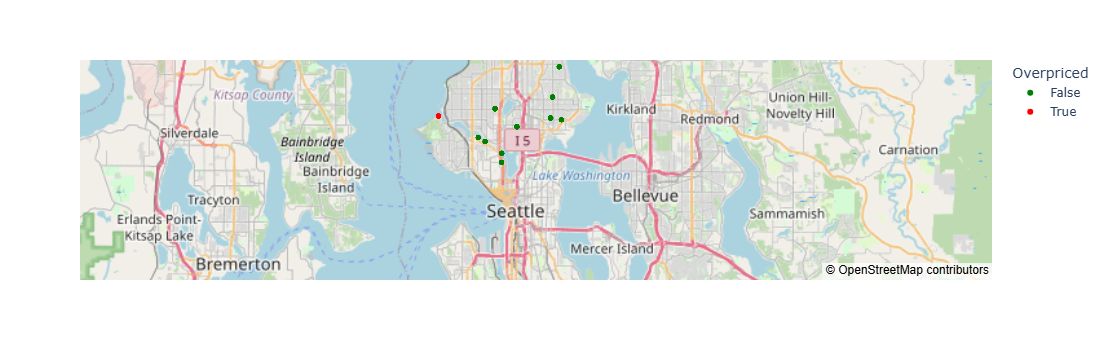

In [8]:

# we can easily plot all houses, based on their latitude & longitude coordinates, and make distinctions between overvalued houses (shown in red)
# and undervalued houses (shown in green).

import plotly.express as px
import pandas as pd


# Plotting using Plotly Express
fig = px.scatter_mapbox(df, lat='Latitude', lon='Longitude', hover_name='Address',
                        color='Overpriced', color_discrete_map={False: 'green', True: 'red'},
                        zoom=10, hover_data=['Original_Price', 'Original_Beds', 'Original_Baths', 'Original_SqFt'])
fig.update_layout(mapbox_style="open-street-map")
fig.show()


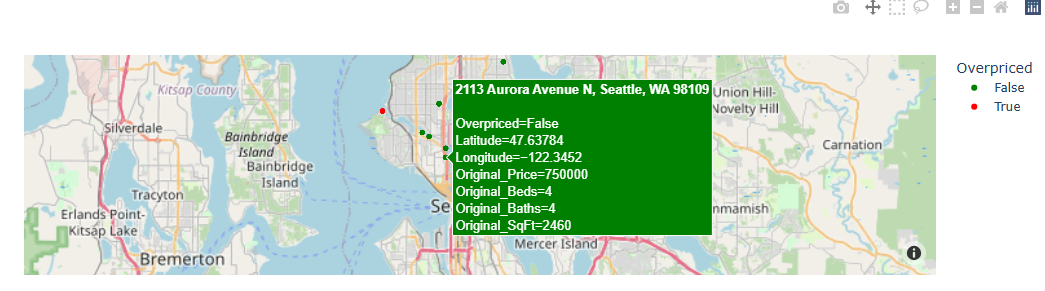

In [31]:

from IPython.display import Image
from IPython.core.display import HTML 
PATH = "C:\\Users\\ryan_\\Desktop\\"
Image(filename = PATH + "not_overpriced.png")


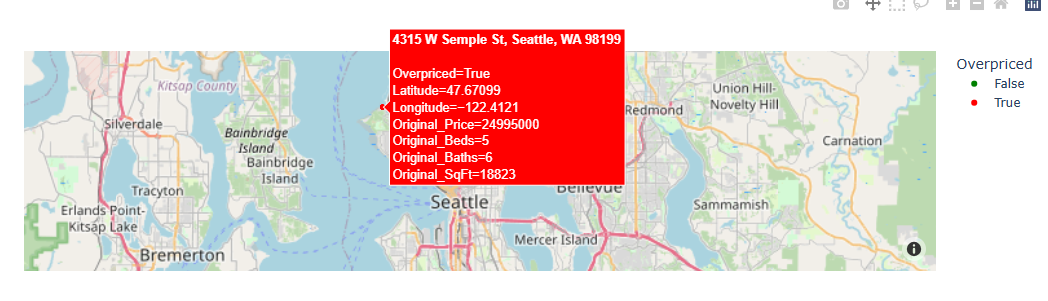

In [32]:

from IPython.display import Image
from IPython.core.display import HTML 
PATH = "C:\\Users\\ryan_\\Desktop\\"
Image(filename = PATH + "overpriced.png")


In [20]:

df_new = df[['Address', 'Original_Price', 'Original_Beds', 'Original_Baths', 'Original_SqFt', 'ZipCode']]
print(df_new.shape)
display(df_new.head())


(220, 6)


Address  Original_Price  \
0             915 NW 105th Street, Seattle, WA 98177        800000.0   
1     3015 SW Avalon Way UNIT 305, Seattle, WA 98126        439950.0   
2  2706 Westlake Avenue N UNIT 76, Seattle, WA 98109        399000.0   
3       624 W Ewing Street UNIT 3, Seattle, WA 98119        250000.0   
4              9725 51st Avenue S, Seattle, WA 98118        300000.0   

   Original_Beds  Original_Baths  Original_SqFt ZipCode  
0            2.0             1.0          820.0   98177  
1            2.0             2.0          810.0   98126  
2            2.0             1.0          583.0   98109  
3            1.0             1.0          450.0   98119  
4            1.0             1.0          530.0   98118

In [22]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error


# Feature selection
X = df_new[['Original_Beds', 'Original_Baths', 'Original_SqFt']]
y = df_new['Original_Price']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')


MAE: 374153.47414209484
RMSE: 420294.1739597075


In [23]:

from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Ensure ZipCode is treated as a categorical variable
df['ZipCode'] = df['ZipCode'].astype(str)

# Encoding ZipCode as it is a categorical variable
label_encoder = LabelEncoder()
df_new['ZipCode'] = label_encoder.fit_transform(df['ZipCode'])

# Define features and target
X = df_new[['Original_Beds', 'Original_Baths', 'Original_SqFt']]
y = df_new['Original_Price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Using LazyRegressor
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# Display the results
display(models)


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 14.33it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23
[LightGBM] [Info] Number of data points in the train set: 154, number of used features: 3
[LightGBM] [Info] Start training from score 2430800.974026
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

Adjusted R-Squared  R-Squared       RMSE  \
Model                                                                     
DecisionTreeRegressor                        1.00       1.00       0.00   
RandomForestRegressor                        1.00       1.00       0.00   
ExtraTreeRegressor                           1.00       1.00       0.00   
ExtraTreesRegressor                          1.00       1.00       0.00   
GaussianProcessRegressor                     1.00       1.00       0.00   
KNeighborsRegressor                          1.00       1.00       0.00   
BaggingRegressor                             1.00       1.00       0.00   
XGBRegressor                                 1.00       1.00       0.74   
GradientBoostingRegressor                    1.00       1.00    1700.44   
AdaBoostRegressor                            1.00       1.00  112013.27   
PoissonRegressor                             1.00       1.00  234960.68   
LarsCV                                       1.00       1.00  408818.35   
TransformedTargetRegressor                   1.00       1.00  408818.35   
OrthogonalMatchingPursuitCV                  1.00       1.00  408818.35   
LinearRegression                             1.00       1.00  408818.35   
LassoLarsIC                                  1.00       1.00  408818.35   
LassoLarsCV                                  1.00       1.00  408818.35   
Lars                                         1.00       1.00  408818.35   
Lasso                                        1.00       1.00  408818.41   
LassoLars                                    1.00       1.00  408818.87   
SGDRegressor                                 1.00       1.00  410077.16   
RidgeCV                                      1.00       1.00  410928.22   
LassoCV                                      1.00       1.00  412791.00   
Ridge                                        1.00       1.00  439234.68   
OrthogonalMatchingPursuit                    0.98       0.98 1022143.64   
KernelRidge                                  0.91       0.91 2496499.77   
ElasticNet                                   0.87       0.88 2901850.51   
TweedieRegressor                             0.77       0.78 3866159.41   
GammaRegressor                               0.59       0.61 5212921.62   
LGBMRegressor                                0.46       0.48 6003584.11   
HistGradientBoostingRegressor                0.46       0.48 6003584.11   
RANSACRegressor                              0.24       0.27 7105437.97   
HuberRegressor                               0.08       0.13 7794074.30   
ElasticNetCV                                -0.09      -0.04 8484872.65   
BayesianRidge                               -0.09      -0.04 8487534.15   
DummyRegressor                              -0.09      -0.04 8487534.15   
SVR                                         -0.21      -0.15 8938923.47   
QuantileRegressor                           -0.21      -0.15 8938936.38   
NuSVR                                       -0.21      -0.15 8957652.61   
PassiveAggressiveRegressor                  -0.27      -0.22 9191923.38   
LinearSVR                                   -0.29      -0.23 9257800.97   
MLPRegressor                                -0.29      -0.23 9257853.07   

                               Time Taken  
Model                                      
DecisionTreeRegressor                0.01  
RandomForestRegressor                0.15  
ExtraTreeRegressor                   0.01  
ExtraTreesRegressor                  0.12  
GaussianProcessRegressor             0.03  
KNeighborsRegressor                  0.02  
BaggingRegressor                     0.04  
XGBRegressor                         0.13  
GradientBoostingRegressor            0.08  
AdaBoostRegressor                    0.02  
PoissonRegressor                     0.02  
LarsCV                               0.02  
TransformedTargetRegressor           0.01  
OrthogonalMatchingPursuitCV          0.02  
LinearRegression          

In [24]:

# Importing pandas library
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import xgboost as xgb
xgb_model = xgb.XGBRegressor()


# Assuming 'Original_Price' is the target variable
X = df_new[['Original_Beds', 'Original_Baths', 'Original_SqFt']]
y = df_new['Original_Price']
     
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Defining the grid of hyperparameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Performing grid search
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Getting the best model
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')

# Assuming best_model is your trained XGBRegressor model
y_pred = best_model.predict(X_test)
# Calculate R^2 score
r2 = r2_score(y_test, y_pred)
print(f'R^2 Score: {r2:.2f}')


Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Mean Squared Error: 7.36
R^2 Score: 1.00


In [29]:

# # Making predictions for all records in the original dataframe
# df_predictions = df_new.copy()  # Create a copy of the original dataframe
# df_predictions['XGB_Predicted_Price'] = best_model.predict(df_new[['Original_Beds', 'Original_Baths', 'Original_SqFt']])  # Make predictions

# df_predictions['Price_Difference'] = df_predictions['Price'] - df_predictions['XGB_Predicted_Price']
# df_predictions['Prediction_Status'] = df_predictions['Price_Difference'].apply(lambda x: 'Overpriced' if x > 0 else 'Underpriced' if x < 0 else 'Fair Price')


# # Calculating the differences
# df_predictions['Price_Minus_XGB_Predicted_Price'] = df_predictions['Price'] - df_predictions['XGB_Predicted_Price']

# # If there is no difference, we get NaN values. Let's clean this up and replace NAN with 0.
# df_predictions['Price_Minus_XGB_Predicted_Price'] = df_predictions['Price_Minus_XGB_Predicted_Price'].fillna(0)


# # Displaying the final formatted results
# display(df_predictions.head())


In [39]:

# Importing necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Assuming df is your DataFrame and 'Price' is the target variable
# Features and target
X = df_new[['Original_Beds', 'Original_Baths', 'Original_SqFt']]
y = df_new['Original_Price']

# Feature Scaling
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Target Scaling (if needed)
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# XGBoost model
xgb_model = xgb.XGBRegressor()

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Performing grid search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Getting the best model
best_model = grid_search.best_estimator_

# Predictions
y_pred_scaled = best_model.predict(X_test)

# Inverse scaling for the target
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R^2 Score: {r2:.2f}')

# Making predictions for all records in the original dataframe
X_all_scaled = scaler_X.transform(df_new[['Original_Beds', 'Original_Baths', 'Original_SqFt']])
df_predictions = df_new.copy()
df_predictions['XGB_Predicted_Price'] = scaler_y.inverse_transform(best_model.predict(X_all_scaled).reshape(-1, 1)).flatten()

df_predictions['Price_Difference'] = df_predictions['Original_Price'] - df_predictions['XGB_Predicted_Price']
df_predictions['Prediction_Status'] = df_predictions['Price_Difference'].apply(lambda x: 'Overpriced' if x > 0 else 'Underpriced' if x < 0 else 'Fair Price')

# Sort by column named 'Price_Difference'; makes it easier to see overvalued homes and undervalues homes, relative to each other.
df_predictions = df_predictions.sort_values(by=['Price_Difference'], ascending=False)

# Display the final formatted results
display(df_predictions)


Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Mean Squared Error: 2545986.43
R^2 Score: 1.00


Address  Original_Price  \
137                4315 W Semple St, Seattle, WA 98199     24995000.00   
170                4315 W Semple St, Seattle, WA 98199     24995000.00   
115                4315 W Semple St, Seattle, WA 98199     24995000.00   
126                4315 W Semple St, Seattle, WA 98199     24995000.00   
27                 4315 W Semple St, Seattle, WA 98199     24995000.00   
38                 4315 W Semple St, Seattle, WA 98199     24995000.00   
82                 4315 W Semple St, Seattle, WA 98199     24995000.00   
16                 4315 W Semple St, Seattle, WA 98199     24995000.00   
148                4315 W Semple St, Seattle, WA 98199     24995000.00   
159                4315 W Semple St, Seattle, WA 98199     24995000.00   
93                 4315 W Semple St, Seattle, WA 98199     24995000.00   
71                 4315 W Semple St, Seattle, WA 98199     24995000.00   
181                4315 W Semple St, Seattle, WA 98199     24995000.00   
60                 4315 W Semple St, Seattle, WA 98199     24995000.00   
192                4315 W Semple St, Seattle, WA 98199     24995000.00   
5                  4315 W Semple St, Seattle, WA 98199     24995000.00   
203                4315 W Semple St, Seattle, WA 98199     24995000.00   
49                 4315 W Semple St, Seattle, WA 98199     24995000.00   
214                4315 W Semple St, Seattle, WA 98199     24995000.00   
104                4315 W Semple St, Seattle, WA 98199     24995000.00   
66              915 NW 105th Street, Seattle, WA 98177       800000.00   
77              915 NW 105th Street, Seattle, WA 98177       800000.00   
55              915 NW 105th Street, Seattle, WA 98177       800000.00   
88              915 NW 105th Street, Seattle, WA 98177       800000.00   
0               915 NW 105th Street, Seattle, WA 98177       800000.00   
99              915 NW 105th Street, Seattle, WA 98177       800000.00   
121             915 NW 105th Street, Seattle, WA 98177       800000.00   
132             915 NW 105th Street, Seattle, WA 98177       800000.00   
143             915 NW 105th Street, Seattle, WA 98177       800000.00   
154             915 NW 105th Street, Seattle, WA 98177       800000.00   
165             915 NW 105th Street, Seattle, WA 98177       800000.00   
176             915 NW 105th Street, Seattle, WA 98177       800000.00   
187             915 NW 105th Street, Seattle, WA 98177       800000.00   
198             915 NW 105th Street, Seattle, WA 98177       800000.00   
209             915 NW 105th Street, Seattle, WA 98177       800000.00   
44              915 NW 105th Street, Seattle, WA 98177       800000.00   
110             915 NW 105th Street, Seattle, WA 98177       800000.00   
11              915 NW 105th Street, Seattle, WA 98177       800000.00   
22              915 NW 105th Street, Seattle, WA 98177       800000.00   
33              915 NW 105th Street, Seattle, WA 98177       800000.00   
219          8030 Meridian Avenue N, Seattle, WA 98103      1150000.00   
142          8030 Meridian Avenue N, Seattle, WA 98103      1150000.00   
175          8030 Meridian Avenue N, Seattle, WA 98103      1150000.00   
32           8030 Meridian Avenue N, Seattle, WA 98103      1150000.00   
164          8030 Meridian Avenue N, Seattle, WA 98103      1150000.00   
153          8030 Meridian Avenue N, Seattle, WA 98103      1150000.00   
131          8030 Meridian Avenue N, Seattle, WA 98103      1150000.00   
76           8030 Meridian Avenue N, Seattle, WA 98103      1150000.00   
21           8030 Meridian Avenue N, Seattle, WA 98103      1150000.00   
120          8030 Meridian Avenue N, Seattle, WA 98103      1150000.00   
87           8030 Meridian Avenue N, Seattle, WA 98103      1150000.00   
109          8030 Meridian Avenue N, Seattle, WA 98103      1150000.00   
98           8030 Meridian Avenue N, Seattle, WA 98103      1150000.00   
10           8030 Meridian Avenue N, Seattle, WA 98

In [ ]:

# Predicting house prices based on homeowner asking prices can be useful, but there are more robust methods and datasets that can 
# improve accuracy. Here are several approaches and factors to consider for predicting house prices and understanding the market:
# 1. Historical Sales Data
# Source: Real estate websites, public records, and real estate data providers.

# 2. Comparable Market Analysis (CMA)
# Source: Real estate agents often perform CMA using MLS (Multiple Listing Service) data.

# 3. Machine Learning Models
# Source: Various data sources including historical sales, current listings, economic indicators, and neighborhood characteristics.

# 4. Economic and Market Indicators
# Source: Government reports, economic research firms.

# 5. Real Estate Market Sentiment
# Source: Surveys, social media, and market reports.

# 6. Property Features and Condition
# Source: Property listings, home inspections.
    

In [ ]:

# If you don't have an Offer_Price field and want to predict the likelihood of acceptance based on hypothetical offers (e.g., 5% or 10% 
# less than the asking price), you can simulate the offers by creating new features that represent these hypothetical scenarios. Here's 
# how you can adjust the approach to incorporate these hypothetical offer prices.


# We will need to do three things:

# Data Preparation: 
# Hypothetical offer prices are created by reducing the asking price (Price) by 5% and 10%.

# Feature Engineering
# Calculate the percentage difference for hypothetical offers and use it to predict the likelihood of acceptance.

# Model Building
# Use logistic regression or another suitable classification algorithm to model the probability of acceptance.


In [37]:

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# Creating hypothetical offer prices
df['Offer_5_Percent_Less'] = df_new['Original_Price'] * 0.95
df['Offer_10_Percent_Less'] = df_new['Original_Price'] * 0.90

# Calculating percentage difference from asking price
df['Percentage_Difference_5_Percent'] = -0.05
df['Percentage_Difference_10_Percent'] = -0.10

# Synthetic likelihood of acceptance
# Assuming the acceptance likelihood decreases as the offer price decreases
def acceptance_likelihood(percentage_diff):
    # Using a simple linear function for synthetic data
    return np.clip(1 + percentage_diff * 10, 0, 1)

df['Likelihood_Accept_5_Percent'] = df['Percentage_Difference_5_Percent'].apply(acceptance_likelihood)
df['Likelihood_Accept_10_Percent'] = df['Percentage_Difference_10_Percent'].apply(acceptance_likelihood)

# Prepare data for logistic regression
features = ['Beds', 'Baths', 'SqFt', 'Percentage_Difference_5_Percent', 'Percentage_Difference_10_Percent']
df_long = df.melt(id_vars=['Original_Price', 'Original_Beds', 'Original_Baths', 'Original_SqFt'], 
                  value_vars=['Percentage_Difference_5_Percent', 'Percentage_Difference_10_Percent'], 
                  var_name='Offer_Type', value_name='Percentage_Difference')

df_long['Likelihood_Accept'] = df_long.apply(lambda row: acceptance_likelihood(row['Percentage_Difference']), axis=1)
df_long['Accepted'] = np.random.binomial(1, df_long['Likelihood_Accept'])

X = df_long[['Original_Beds', 'Original_Baths', 'Original_SqFt', 'Percentage_Difference']]
y = df_long['Accepted']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training a logistic regression model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Making predictions
def predict_acceptance_probability(model, scaler, beds, baths, sqft, percentage_difference):
    input_data = pd.DataFrame({
        'Original_Beds': [beds],
        'Original_Baths': [baths],
        'Original_SqFt': [sqft],
        'Percentage_Difference': [percentage_difference]
    })
    input_scaled = scaler.transform(input_data)
    prob = model.predict_proba(input_scaled)[:, 1]
    return prob[0]

# Example usage
beds = 3
baths = 2
sqft = 1500

# Predict the likelihood of acceptance for a 5% less offer
prob_5_percent = predict_acceptance_probability(model, scaler, beds, baths, sqft, -0.05)
print(f'Probability of acceptance for 5% less offer: {prob_5_percent:.2f}')

# Predict the likelihood of acceptance for a 10% less offer
prob_10_percent = predict_acceptance_probability(model, scaler, beds, baths, sqft, -0.10)
print(f'Probability of acceptance for 10% less offer: {prob_10_percent:.2f}')


Probability of acceptance for 5% less offer: 0.60
Probability of acceptance for 10% less offer: 0.01


In [ ]:

# The hypothetical offer prices are calculated by reducing the Price by 5% and 10%.
# The Percentage_Difference is calculated as -0.05 for a 5% reduction and -0.10 for a 10% reduction.

# A synthetic likelihood function is created, assuming the likelihood of acceptance decreases as the offer price decreases. This is a linear 
# function for simplicity, but you can adjust it based on more complex assumptions.

# The data is reshaped to a long format to prepare it for modeling.
# A synthetic Accepted column is created based on the synthetic likelihood.

# Logistic regression is used to model the likelihood of acceptance based on features including Beds, Baths, SqFt, and Percentage_Difference.

# The trained model is used to predict the probability of acceptance for new hypothetical offers.

# The synthetic likelihood function is plotted for visualization purposes.
